# `Sampler`

In [1]:
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd

## Intro

Welcome! In this section you'll learn about `Sampler`-class. Instances of `Sampler` can be used for flexible sampling of multivariate distributions.

To begin with, `Sampler` gives rise to several building-blocks classes such as
- `NumpySampler`, or `NS`
- `ScipySampler` - `SS`

What's more, `Sampler` incorporates a set of operations on `Sampler`-instances, among which are
- "`|`" for building a mixture of two samplers: `s = s1 | s2`
- "`&`" for setting a mixture-weight of a sampler: `s = 0.6 & s1 | 0.4 & s2`
- " `truncate`" for truncating the support of underlying sampler's distribution: `s.truncate(high=[1.0, 1.5])`
- ..all arithmetic operations: `s = s1 + s2` or `s = s1 + 0.5`

These operations can be used for combining building-blocks samplers into complex multivariate-samplers, just like that:

In [2]:
from dataset import NS

# truncated normal and uniform
ns1 = NS('n', dim=2).truncate(2.0, 0.8, lambda m: np.sum(np.abs(m), axis=1)) + 4
ns2 = 2 * NS('u', dim=2).truncate(1, expr=lambda m: np.sum(m, axis=1)) - (1, 1)
ns3 = NS('n', dim=2).truncate(1.5, expr=lambda m: np.sum(np.square(m), axis=1)) + (4, 0)
ns4 = ((NS('n', dim=2).truncate(2.5, expr=lambda m: np.sum(np.square(m), axis=1)) * 4)
       .apply(lambda m: m.astype(np.int)) / 4 + (0, 3))

# a mixture of all four
ns = 0.4 & ns1 | 0.2 & ns2 | 0.39 & ns3 | 0.01 & ns4

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


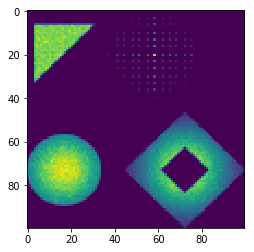

In [3]:
# take a look at the heatmap of our sampler:
h = np.histogramdd(ns.sample(int(1e6)), bins=100, normed=True)
plt.imshow(h[0])

## Building `Samplers`

### 1. Numpy, Scipy, TensorFlow - `Samplers`

To build a `NumpySampler`(`NS`) you need to specify a name of distribution from `numpy.random` (or its [alias](https://github.com/analysiscenter/dataset/blob/master/dataset/sampler.py#L15)) and the number of independent dimensions:

In [4]:
from dataset import NS
ns = NS('n', dim=2)

take a look at a sample generated by our sampler:

In [5]:
smp = ns.sample(size=200)

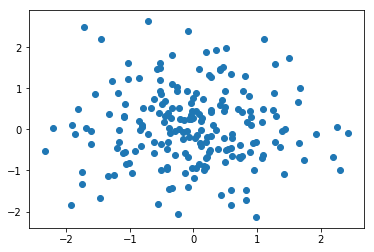

In [6]:
plt.scatter(*np.transpose(smp))

The same goes for `ScipySampler` based on `scipy.stats`-distributions, or `SS` ("mvn" stands for multivariate-normal):

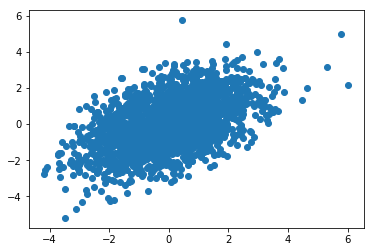

In [7]:
from dataset import SS
ss = SS('mvn', mean=[0, 0], cov=[[2, 1], [1, 2]])  # note also that you can pass the same params as in
smp = ss.sample(2000)                              # scipy.sample.multivariate_normal, such as `mean` and `cov` 
plt.scatter(*np.transpose(smp))

### 2. `HistoSampler` as an estimate of a distribution generating a cloud of points

`HistoSampler`, or `HS` can be used for building samplers, with underlying distributions given by a histogram. You can either pass a `np.histogram`-output into the initialization of `HS`

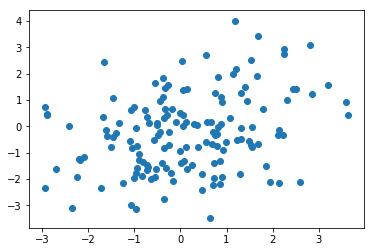

In [8]:
from dataset import HS
histo = np.histogramdd(ss.sample(1000000))
hs = HS(histo)
plt.scatter(*np.transpose(hs.sample(150)))

...or you can specify empty bins and estimate its weights using a method `HS.update` and a cloud of points:

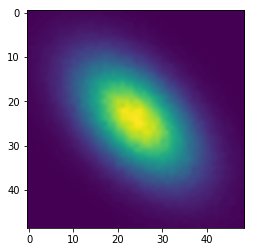

In [9]:
hs = HS(edges=2 * [np.linspace(-4, 4)])
hs.update(ss.sample(1000000))
plt.imshow(hs.bins, interpolation='bilinear')

### 3. Algebra of `Samplers`; operations on `Samplers`

`Sampler`-instances support artithmetic operations (`+`, `*`, `-`,...). Arithmetics works on either
* (`Sampler`, `Sampler`) - pair
* (`Sampler`, `array-like`) - pair

In [10]:
# blur using "+"
u = NS('u', dim=2)
noise = NS('n', dim=2)
blurred = u + noise * 0.2 # decrease the magnitude of the noise
both = blurred | u + (2, 2)

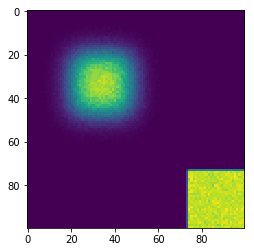

In [11]:
plt.imshow(np.histogramdd(both.sample(1000000), bins=100)[0])

You may also want to truncate a sampler's distribution so that sampling points belong to a specific region. The common use-case is to sample normal points inside a box.

..or, inside a ring: 

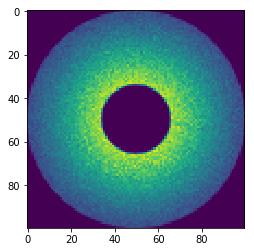

In [12]:
n = NS('n', dim=2).truncate(3, 0.3, expr=lambda m: np.sum(m**2, axis=1))
plt.imshow(np.histogramdd(n.sample(1000000), bins=100)[0])

Not infrequently you need to obtain "normal" sample in integers. For this you can use `Sampler.apply` method:

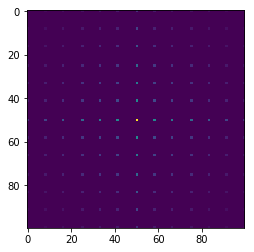

In [13]:
n = (4 * NS('n', dim=2)).apply(lambda m: m.astype(np.int)).truncate([6, 6], [-6, -6])
plt.imshow(np.histogramdd(n.sample(1000000), bins=100)[0])

Note that `Sampler.apply`-method allows you to add an arbitrary transformation to a sampler. For instance, [Box-Muller](https://en.wikipedia.org/wiki/Box–Muller_transform) transform:

In [14]:
bm = lambda vec2: np.sqrt(-2 * np.log(vec2[:, 0:1])) * np.concatenate([np.cos(2 * np.pi * vec2[:, 1:2]),
                                                                       np.sin(2 * np.pi * vec2[:, 1:2])], axis=1)
n = NS('u', dim=2).apply(bm)

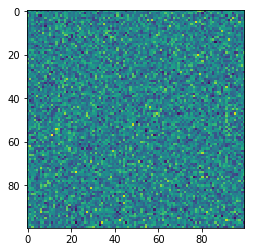

In [15]:
plt.imshow(np.histogramdd(u.sample(1000000), bins=100)[0])

Another useful thing is coordinate stacking ("&" stands for multiplication of distribution functions):

In [16]:
n, u = NS('n'), SS('u')  # initialize one-dimensional notrmal and uniform samplers
s = n & u  # stack them together
s.sample(3)

array([[ 0.03995169,  0.96598141],
       [-0.55054911,  0.62998933],
       [ 1.68657254,  0.44523795]])

### 4. Alltogether

In [17]:
ns1 = NS('n', dim=2).truncate(2.0, 0.8, lambda m: np.sum(np.abs(m), axis=1)) + 4
ns2 = 2 * NS('u', dim=2).truncate(1, expr=lambda m: np.sum(m, axis=1)) - (1, 1)
ns3 = NS('n', dim=2).truncate(1.5, expr=lambda m: np.sum(np.square(m), axis=1)) + (4, 0)
ns4 = ((NS('n', dim=2).truncate(2.5, expr=lambda m: np.sum(np.square(m), axis=1)) * 4)
       .apply(lambda m: m.astype(np.int)) / 4 + (0, 3))
ns = 0.4 & ns1 | 0.2 & ns2 | 0.39 & ns3 | 0.01 & ns4

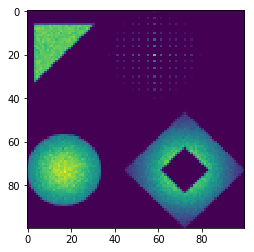

In [18]:
plt.imshow(np.histogramdd(ns.sample(int(1e6)), bins=100, normed=True)[0])